In [1]:
import os 
import numpy as np 
import pickle
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.signal import stft, blackman, get_window
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import pywt

In [2]:
file_names=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))
        
# file_names

# DATA VISUALIZATION

In [3]:
# In the EEG device, 4 leads (here identified by the locations T3, T4, T5, and T6) 
# were used to supply current and establish the EEG reference and could not be used for
# data collection. The acquired data from the 7 leads were identified by F3, F4, Fz, C3, C4, Cz, and Pz

mat = scipy.io.loadmat(file_names[0])
data = mat['o']['data'][0,0]
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

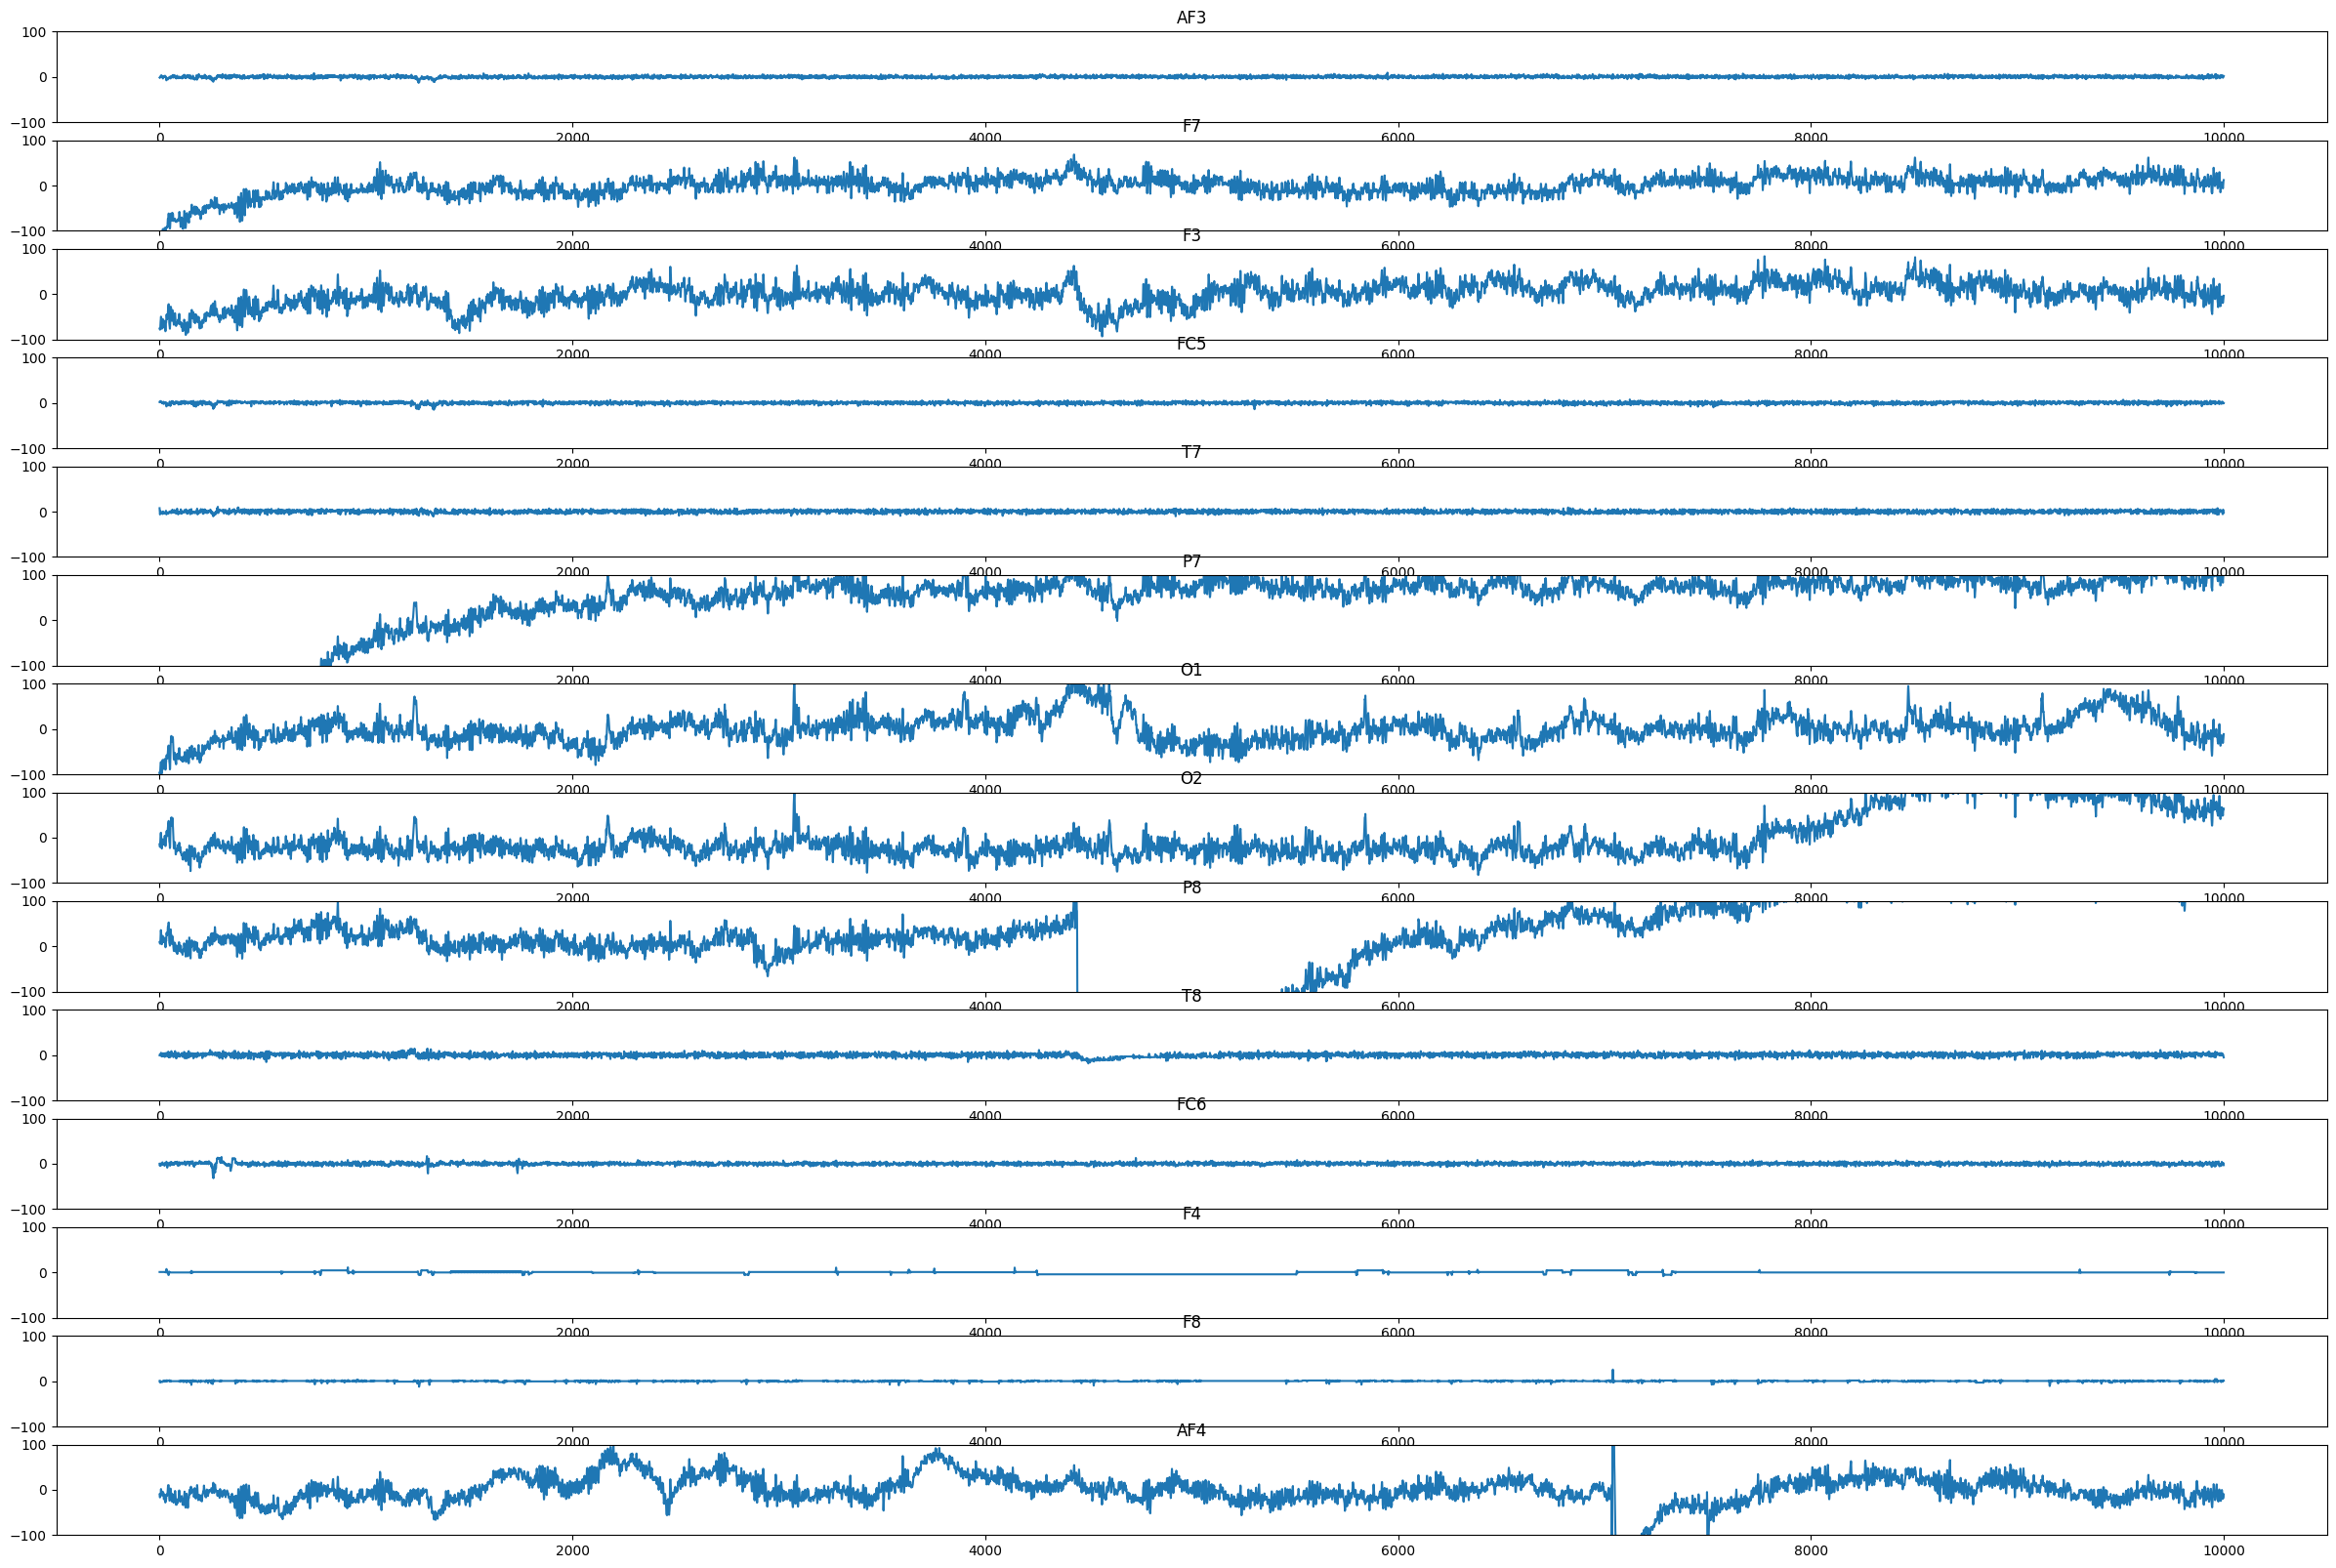

In [4]:
fig, ax = plt.subplots(14,1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30,20)
for i in range(14):
    data_ave = data[5000:15000,i+3]-np.mean(data[5000:15000,i+3]) #+3 because 3 first channel aren't EEG data
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-100,100)

In [5]:
# It seems like only 7 channels are usefull here so we are going to select them

USEFUL_CHANNELS = np.array([1,2,5,6,7,8,13]) + 3 # these are the indices of the interesting channels
SAMPLE_RATE = mat['o']['sampFreq'][0][0][0][0]

channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

# But in the paper to study the channels are [F3, F4, Fz, C3, C4, Cz, Pz]

channels = ['F3', 'F4', 'Fz', 'C3', 'C4', 'Cz', 'Pz']

# It seems like the electrodes are not in the same place so that's why there is a difference
# I'm not sure we can map the first channels names to the second one but currently I will keep it like this

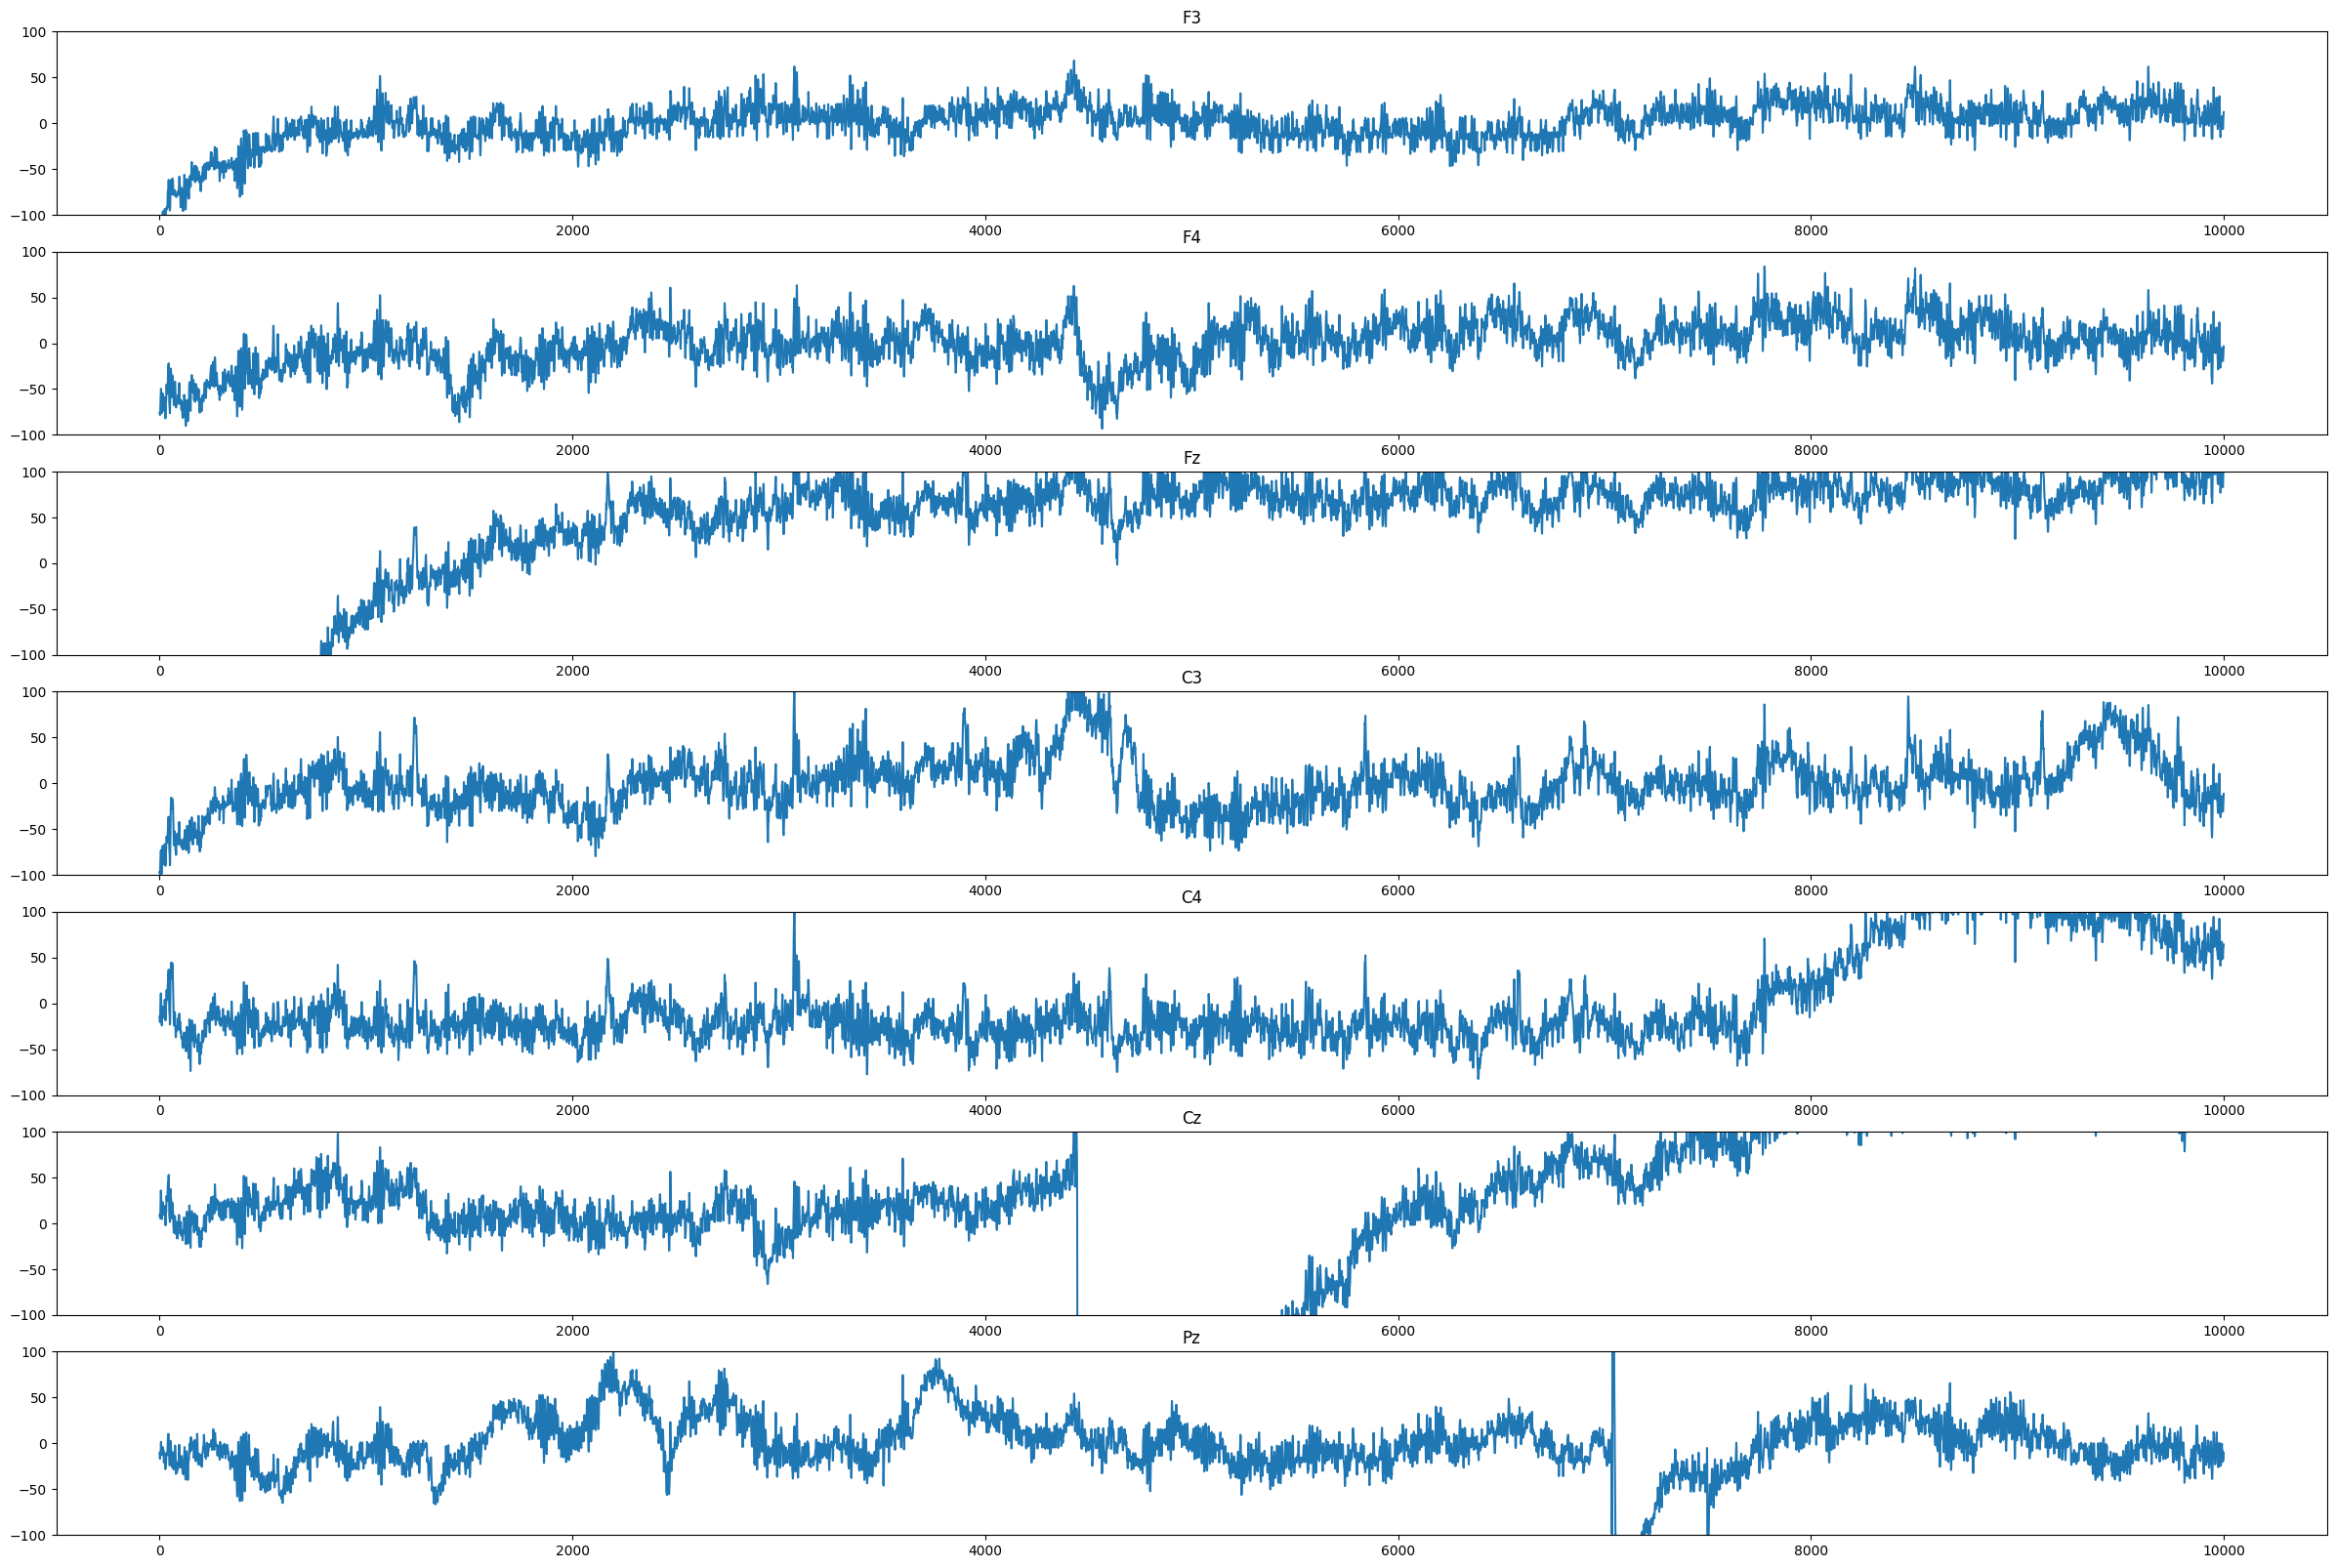

In [6]:
fig, ax = plt.subplots(7,1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30,20)
for i, j in enumerate(USEFUL_CHANNELS):
    data_ave = data[5000:15000,j]-np.mean(data[5000:15000,j]) 
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-100,100)

# DATA PREPROCESSING

In [7]:
# From the paper we know that the records for each subject are next to each other, we don't use the first 2 records each time
sub_record_map = {
    1: ['eeg_record3', 'eeg_record4', 'eeg_record5', 'eeg_record6', 'eeg_record7'],
    2: ['eeg_record10', 'eeg_record11', 'eeg_record12', 'eeg_record13', 'eeg_record14'],
    3: ['eeg_record17', 'eeg_record18', 'eeg_record19', 'eeg_record20', 'eeg_record21'],
    4: ['eeg_record24', 'eeg_record25', 'eeg_record26', 'eeg_record27'],
    5: ['eeg_record31', 'eeg_record32', 'eeg_record33', 'eeg_record34']
}

file_names = file_names[:34] # pick the 34 files

In [8]:
def find_key_by_value(dictionary, value):
    for key, val_list in dictionary.items():
        if value in val_list:
            return key
    return None 

# dL = "10" for 3 class balancing
# dL = "20" for drowsy/undrowsy balancing
# dL = "max" for no balancing
def get_data_from_file_names(file_names, dL, selected_channels, n_channels, sample_rate):
    final_data = {}

    for file_name in tqdm(file_names):
        record = file_name.split('/')[-1][:-4]
        sub_number = find_key_by_value(sub_record_map, record)
        if sub_number: # only load if record is a valid one
            mat = scipy.io.loadmat(file_name)
            data = np.array(mat['o']['data'][0,0]) # select the data
            data = data[:, selected_channels[:n_channels]] # select the 7 channels
            
            # now we want to split the labels, we know the sampling rate is 128 Hz and the ranges are
            # 0min - 10min - 20min - end so we can use a split value
            split_value = 10 * 60 * sample_rate
            focused_data = data[:split_value]
            unfocused_data = data[split_value:split_value*2]
            if dL == "10":
                drowsy_data = data[split_value*2:split_value*3]
            elif dL == "20":
                drowsy_data = data[split_value*2:split_value*4]
            else:
                drowsy_data = data[split_value*2:]
                                
            if sub_number not in final_data.keys():
                final_data[sub_number] = {
                    'focused': [focused_data],
                    'unfocused': [unfocused_data],
                    'drowsy': [drowsy_data]
                }
            else:
                final_data[sub_number]['focused'].append(focused_data)
                final_data[sub_number]['unfocused'].append(unfocused_data)
                final_data[sub_number]['drowsy'].append(drowsy_data)

    # concatenate all the records
    # this was a misstake because when we chose the STFT window we might get the end of a record 
    # and the beginning of another one. So we need to concatenante only after getting the
    # different blocks in the preprocessing for each record
#     for key in final_data.keys():
#         final_data[key]['focused'] = np.concatenate(final_data[key]['focused'], axis=0)
#         final_data[key]['unfocused'] = np.concatenate(final_data[key]['unfocused'], axis=0)
#         final_data[key]['drowsy'] = np.concatenate(final_data[key]['drowsy'], axis=0)
        
    return final_data

In [9]:
def frequency_binning(f_range, bin_size):
    start_freq, end_freq = f_range
    num_bins = int((end_freq - start_freq) / bin_size) + 1
    frequency_bins = np.linspace(start_freq, end_freq, num=num_bins)
    return frequency_bins

def preprocess_data(data, wL, wS, sample_rate, bin_size, f_range, moving_avg):
    preprocessed_data = []
    for channel_data in data.T: # we preprocess each EEG channel independently
#         print('test:', channel_data.shape)

        window_samples = int(wL * sample_rate)
        overlap_samples = int((1 - (wS / sample_rate)) * window_samples)
        window = get_window('blackman', window_samples)
        f, t, Zxx = stft(channel_data, fs=sample_rate, window=window, nperseg=window_samples, noverlap=overlap_samples)
        Zxx = Zxx.T # we want time_step on first dimension
#         print('test:', Zxx.shape)
        
        frequency_bins = frequency_binning(f_range, bin_size)
        bin_indices = np.searchsorted(f, frequency_bins)
        Zxx_restricted = Zxx[:, bin_indices[:-1]] 
#         print('test:', Zxx_restricted.shape)
        
        Zxx_magnitude = np.abs(Zxx_restricted)
        window_size = int(moving_avg * sample_rate) 
        Zxx_smoothed = uniform_filter1d(Zxx_magnitude, size=window_size, axis=1, mode='nearest')
        epsilon = 1e-10
        Zxx_smoothed = np.maximum(Zxx_smoothed, epsilon)
#         print('test:', Zxx_smoothed.shape)
        
        Zxx_db = 10 * np.log10(np.abs(Zxx_smoothed))
#         print('test:', Zxx_db.shape)
        
        preprocessed_data.append(Zxx_db)
    
    preprocessed_data = np.concatenate(preprocessed_data, axis=1)
    
    # I think scaling here was an error, it's better if we scale the whole data together
#     scaler = StandardScaler()
#     Zxx_scaled = scaler.fit_transform(preprocessed_data)
    
    return preprocessed_data

def preprocess_final_data(final_data, wL, wS, sample_rate, bin_size, f_range, moving_avg):
    preprocessed_final_data = {}
    all_preprocessed_data = []  # store all preprocessed data to scale them together
    for sub_number, value in final_data.items():
        preprocessed_category = {}
        for category, data in value.items():
            preprocessed_category[category] = [] 
            for record_data in range(len(data)):
                preprocessed_data = preprocess_data(data[record_data], wL, wS, sample_rate, bin_size, f_range, moving_avg)
                preprocessed_category[category].append(preprocessed_data)
                all_preprocessed_data.append(preprocessed_data)
            preprocessed_category[category] = np.concatenate(preprocessed_category[category], axis=0) 
        preprocessed_final_data[sub_number] = preprocessed_category
    
    # scale the entire preprocessed data
    scaler = StandardScaler()
    all_preprocessed_data = np.concatenate(all_preprocessed_data, axis=0)
    scaled_preprocessed_data = scaler.fit_transform(all_preprocessed_data)
    
    # assign scaled data back to preprocessed_final_data
    index = 0
    for sub_number, value in preprocessed_final_data.items():
        for category, data in value.items():
            preprocessed_final_data[sub_number][category] = scaled_preprocessed_data[index : index + len(data)]
            index += len(data)
    
    return preprocessed_final_data

def load_data_for_exp(file_names, dL, selected_channels, n_channels, sample_rate, wL, wS, bin_size, f_range, moving_avg):
    final_data = get_data_from_file_names(file_names, dL, selected_channels, n_channels, sample_rate)
    preprocessed_final_data = preprocess_final_data(final_data, wL, wS, sample_rate, bin_size, f_range, moving_avg)
    return preprocessed_final_data

# MODELS DEFINITION

In [10]:
class DNN4(nn.Module):
    def __init__(self, input_size):
        super(DNN4, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x
    
    def fit(self, x_train, y_train, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train).long()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
    
    def predict(self, x_test):
        x_test = torch.Tensor(x_test)
        with torch.no_grad():
            outputs = self(x_test)
            _, predicted = torch.max(outputs, 1)
        return predicted

    
class DNN6(nn.Module):
    def __init__(self, input_size):
        super(DNN6, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x
    
    def fit(self, x_train, y_train, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train).long()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
    
    def predict(self, x_test):
        x_test = torch.Tensor(x_test)
        with torch.no_grad():
            outputs = self(x_test)
            _, predicted = torch.max(outputs, 1)
        return np.array(predicted)

    
def get_classifiers(input_size):
    classifiers = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'XGBoost': XGBClassifier(),
        'Neural Network (DNN4)': DNN4(input_size),
        'Neural Network (DNN6)': DNN6(input_size)
    }
    return classifiers

# TRAIN/TEST SPLITS

In [11]:
# Now we want to perform our different split which are :
# - split-by-sample : split train/test for each subject
#    - subject-specific : train/test on a single subject
#    - common-subject : train/test on all subject at once
# - split-by-subject : train on a subject test on another
#    - leave-one-out : 4 subject train 1 subject test

# we don't need any function for this, for example
# if we want leave-one-out on subject 5 we will just select
# 1, 2, 3, 4 keys in final_data for train and 5 for test
# for subject-specific we just pick one key
# for common-subject we just split inside each key

In [12]:
def get_leave_one_out_split(data_dict):
    train_keys = [1, 2, 3, 4]
    test_key = 5
    x_train = np.concatenate([data_dict[key]['focused'] for key in train_keys] +
                             [data_dict[key]['unfocused'] for key in train_keys] +
                             [data_dict[key]['drowsy'] for key in train_keys])
    y_train = np.concatenate([[0] * len(data_dict[key]['focused']) for key in train_keys] +
                             [[1] * len(data_dict[key]['unfocused']) for key in train_keys] +
                             [[2] * len(data_dict[key]['drowsy']) for key in train_keys])
    
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    
    x_test = np.concatenate([data_dict[test_key]['focused'],
                             data_dict[test_key]['unfocused'],
                             data_dict[test_key]['drowsy']])
    y_test = np.concatenate([[0] * len(data_dict[test_key]['focused']),
                             [1] * len(data_dict[test_key]['unfocused']),
                             [2] * len(data_dict[test_key]['drowsy'])])
    return x_train, y_train, x_test, y_test

def get_subject_specific_split(data_dict):
    x = np.concatenate([data_dict['focused'], data_dict['unfocused'], data_dict['drowsy']])
    y = np.concatenate([[0] * len(data_dict['focused']), 
                        [1] * len(data_dict['unfocused']), 
                        [2] * len(data_dict['drowsy'])])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test

def get_common_subject_split(data_dict):
    keys = tmp_data.keys()
    x = np.concatenate([data_dict[key]['focused'] for key in keys] +
                        [data_dict[key]['unfocused'] for key in keys] +
                        [data_dict[key]['drowsy'] for key in keys])
    y = np.concatenate([[0] * len(data_dict[key]['focused']) for key in keys] +
                        [[1] * len(data_dict[key]['unfocused']) for key in keys] +
                        [[2] * len(data_dict[key]['drowsy']) for key in keys])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    return x_train, y_train, x_test, y_test

# EXPERIMENTS

In [13]:
test = True

In [14]:
# I did a quick gridsearch because I didn't know if the problem came from the models
# or the data and it seems like the problem comes from my preprocessing because
# even with optimal HPs I have bad performance

# from sklearn.model_selection import GridSearchCV

# tmp_data = load_data_for_exp(file_names, 
#                                  dL, 
#                                  selected_channels=USEFUL_CHANNELS, 
#                                  n_channels=7, 
#                                  sample_rate=SAMPLE_RATE, 
#                                  wL=4, 
#                                  wS=128, 
#                                  bin_size=0.5, 
#                                  f_range=(0, 18), 
#                                  moving_avg=15)
    
# x_train, y_train, x_test, y_test = get_leave_one_out_split(tmp_data)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rfc = RandomForestClassifier()

# grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring='accuracy', verbose=2)

# grid_search.fit(x_train[:1000], y_train[:1000])
# best_rfc = grid_search.best_estimator_
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# best_rfc.fit(x_train, y_train)
# y_pred = best_rfc.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred, labels=[2], average=None) # 2 is drowsy state and we want the recall score for this

# print("Test accuracy:", accuracy)
# print("Test balanced accuracy:", balanced_accuracy)
# print("Test drowsy recall:", recall[0])
# print("np.unique(y_pred)", np.unique(y_pred, return_counts=True))

In [15]:
# Experiment 1 : data length study

if test :
    dLs = ["10", "20", "max"]

    for dL in dLs:
        print("===> Testing dL =",dL)

        tmp_data = load_data_for_exp(file_names, 
                                     dL, 
                                     selected_channels=USEFUL_CHANNELS, 
                                     n_channels=7, 
                                     sample_rate=SAMPLE_RATE, 
                                     wL=4, 
                                     wS=128, 
                                     bin_size=0.5, 
                                     f_range=(0, 18), 
                                     moving_avg=15)

        x_train, y_train, x_test, y_test = get_leave_one_out_split(tmp_data)
        print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        print("np.unique(y_test)", np.unique(y_test, return_counts=True))

        clfs = get_classifiers(x_train.shape[1])
    #     clfs = {"RF": RandomForestClassifier()}
        for name, clf in clfs.items():
            print("--> Training", name)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            accuracy = accuracy_score(y_test, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, labels=[2], average=None) # 2 is drowsy state and we want the recall score for this
            print("Test accuracy:", accuracy)
            print("Test balanced accuracy:", balanced_accuracy)
            print("Test drowsy recall:", recall[0])
            print("np.unique(y_pred)", np.unique(y_pred, return_counts=True))

        print()

===> Testing dL = 10


100%|██████████| 34/34 [00:11<00:00,  2.98it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (8607, 252) (8607,) (1812, 252) (1812,)
np.unique(y_test) (array([0, 1, 2]), array([604, 604, 604]))
--> Training Random Forest
Test accuracy: 0.35485651214128033
Test balanced accuracy: 0.35485651214128033
Test drowsy recall: 0.4900662251655629
np.unique(y_pred) (array([0, 1, 2]), array([466, 500, 846]))
--> Training SVM
Test accuracy: 0.3901766004415011
Test balanced accuracy: 0.3901766004415011
Test drowsy recall: 0.6854304635761589
np.unique(y_pred) (array([0, 1, 2]), array([ 257,  385, 1170]))
--> Training XGBoost
Test accuracy: 0.32891832229580575
Test balanced accuracy: 0.3289183222958057
Test drowsy recall: 0.46688741721854304
np.unique(y_pred) (array([0, 1, 2]), array([447, 479, 886]))
--> Training Neural Network (DNN4)
Test accuracy: 0.3344370860927152
Test balanced accuracy: 0.3344370860927152
Test drowsy recall: 0.48841059602649006
np.unique(y_pred) (array([0, 1, 2]), array([747, 194, 871]))
--> Training Neural Netw

100%|██████████| 34/34 [00:07<00:00,  4.30it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (11421, 252) (11421,) (2412, 252) (2412,)
np.unique(y_test) (array([0, 1, 2]), array([ 604,  604, 1204]))
--> Training Random Forest
Test accuracy: 0.4622719734660033
Test balanced accuracy: 0.36369753507440244
Test drowsy recall: 0.7599667774086378
np.unique(y_pred) (array([0, 1, 2]), array([ 368,  277, 1767]))
--> Training SVM
Test accuracy: 0.521558872305141
Test balanced accuracy: 0.3661598938050501
Test drowsy recall: 0.9908637873754153
np.unique(y_pred) (array([0, 1, 2]), array([  83,    3, 2326]))
--> Training XGBoost
Test accuracy: 0.4556384742951907
Test balanced accuracy: 0.35926785622611895
Test drowsy recall: 0.7466777408637874
np.unique(y_pred) (array([0, 1, 2]), array([ 382,  276, 1754]))
--> Training Neural Network (DNN4)
Test accuracy: 0.49502487562189057
Test balanced accuracy: 0.3415656421200854
Test drowsy recall: 0.9584717607973422
np.unique(y_pred) (array([0, 1, 2]), array([  98,   13, 2301]))
--> Training 

100%|██████████| 34/34 [00:07<00:00,  4.45it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (13703, 252) (13703,) (3539, 252) (3539,)
np.unique(y_test) (array([0, 1, 2]), array([ 604,  604, 2331]))
--> Training Random Forest
Test accuracy: 0.6162757841198079
Test balanced accuracy: 0.37730350975384086
Test drowsy recall: 0.867009867009867
np.unique(y_pred) (array([0, 1, 2]), array([ 395,  175, 2969]))
--> Training SVM
Test accuracy: 0.6597909013845719
Test balanced accuracy: 0.33717634379886036
Test drowsy recall: 0.9982839982839983
np.unique(y_pred) (array([0, 2]), array([  20, 3519]))
--> Training XGBoost
Test accuracy: 0.5996044080248658
Test balanced accuracy: 0.3680487488434509
Test drowsy recall: 0.8425568425568426
np.unique(y_pred) (array([0, 1, 2]), array([ 431,  225, 2883]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6586606385984741
Test balanced accuracy: 0.33374220957002415
Test drowsy recall: 0.9995709995709996
np.unique(y_pred) (array([0, 2]), array([   3, 3536]))
--> Training Neural Network (DN

In [16]:
# Experiment 2 : STFT quantitative study

if test :
    wLs = [4,10,30,60]
    wSs = [168,384,896,1152]

    for wL in wLs:
        for wS in wSs:
            print("===> Testing wL =",wL,"wS =", wS)

            tmp_data = load_data_for_exp(file_names, 
                                         dL=20, 
                                         selected_channels=USEFUL_CHANNELS, 
                                         n_channels=7, 
                                         sample_rate=SAMPLE_RATE, 
                                         wL=wL, 
                                         wS=wS, 
                                         bin_size=0.5, 
                                         f_range=(0, 18), 
                                         moving_avg=15)

            x_train, y_train, x_test, y_test = get_leave_one_out_split(tmp_data)
            print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
            print("np.unique(y_test)", np.unique(y_test, return_counts=True))

            clfs = get_classifiers(x_train.shape[1])
    #         clfs = {"RF": RandomForestClassifier()}
            for name, clf in clfs.items():
                print("--> Training", name)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_test)
                accuracy = accuracy_score(y_test, y_pred)
                balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred, labels=[2], average=None) # 2 is drowsy state and we want the recall score for this
                print("Test accuracy:", accuracy)
                print("Test balanced accuracy:", balanced_accuracy)
                print("Test drowsy recall:", recall[0])
                print("np.unique(y_pred)", np.unique(y_pred, return_counts=True))

            print()

===> Testing wL = 4 wS = 168


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (10479, 252) (10479,) (2705, 252) (2705,)
np.unique(y_test) (array([0, 1, 2]), array([ 464,  464, 1777]))
--> Training Random Forest
Test accuracy: 0.6118299445471349
Test balanced accuracy: 0.3810458832204606
Test drowsy recall: 0.8564997186268992
np.unique(y_pred) (array([0, 1, 2]), array([ 326,  145, 2234]))
--> Training SVM
Test accuracy: 0.6576709796672828
Test balanced accuracy: 0.3358317324174154
Test drowsy recall: 0.9988745075970737
np.unique(y_pred) (array([0, 2]), array([  10, 2695]))
--> Training XGBoost
Test accuracy: 0.5848428835489834
Test balanced accuracy: 0.36204430494375767
Test drowsy recall: 0.8210467079347215
np.unique(y_pred) (array([0, 1, 2]), array([ 343,  179, 2183]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6569316081330869
Test balanced accuracy: 0.33386414207077664
Test drowsy recall: 0.9994372537985369
np.unique(y_pred) (array([1, 2]), array([   4, 2701]))
--> Training Neural Network (DN

100%|██████████| 34/34 [00:07<00:00,  4.63it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (4599, 252) (4599,) (1187, 252) (1187,)
np.unique(y_test) (array([0, 1, 2]), array([204, 204, 779]))
--> Training Random Forest
Test accuracy: 0.6208930075821398
Test balanced accuracy: 0.3985816406151678
Test drowsy recall: 0.8575096277278562
np.unique(y_pred) (array([0, 1, 2]), array([145,  74, 968]))
--> Training SVM
Test accuracy: 0.6596461668070767
Test balanced accuracy: 0.3446936326948409
Test drowsy recall: 0.9948652118100129
np.unique(y_pred) (array([0, 2]), array([  20, 1167]))
--> Training XGBoost
Test accuracy: 0.620050547598989
Test balanced accuracy: 0.3993598295116078
Test drowsy recall: 0.8549422336328626
np.unique(y_pred) (array([0, 1, 2]), array([146,  78, 963]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6293176074136478
Test balanced accuracy: 0.3353197076862409
Test drowsy recall: 0.9422336328626444
np.unique(y_pred) (array([1, 2]), array([  74, 1113]))
--> Training Neural Network (DNN6)
Test accur

100%|██████████| 34/34 [00:08<00:00,  4.05it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (1983, 252) (1983,) (511, 252) (511,)
np.unique(y_test) (array([0, 1, 2]), array([ 88,  88, 335]))
--> Training Random Forest
Test accuracy: 0.6066536203522505
Test balanced accuracy: 0.3782790592492085
Test drowsy recall: 0.8507462686567164
np.unique(y_pred) (array([0, 1, 2]), array([ 57,  37, 417]))
--> Training SVM
Test accuracy: 0.6555772994129159
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([511]))
--> Training XGBoost
Test accuracy: 0.5753424657534246
Test balanced accuracy: 0.36235866123925825
Test drowsy recall: 0.8029850746268656
np.unique(y_pred) (array([0, 1, 2]), array([ 66,  45, 400]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6555772994129159
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([511]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6555772994129159
Test balanced accuracy: 0.

100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (1540, 252) (1540,) (396, 252) (396,)
np.unique(y_test) (array([0, 1, 2]), array([ 68,  68, 260]))
--> Training Random Forest
Test accuracy: 0.6313131313131313
Test balanced accuracy: 0.40015082956259423
Test drowsy recall: 0.8769230769230769
np.unique(y_pred) (array([0, 1, 2]), array([ 44,  25, 327]))
--> Training SVM
Test accuracy: 0.6565656565656566
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([396]))
--> Training XGBoost
Test accuracy: 0.5934343434343434
Test balanced accuracy: 0.380920060331825
Test drowsy recall: 0.8192307692307692
np.unique(y_pred) (array([0, 1, 2]), array([ 47,  38, 311]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6439393939393939
Test balanced accuracy: 0.3558823529411765
Test drowsy recall: 0.95
np.unique(y_pred) (array([0, 1, 2]), array([ 17,   8, 371]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6565656565656566
Test balan

100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (4229, 252) (4229,) (1090, 252) (1090,)
np.unique(y_test) (array([0, 1, 2]), array([188, 188, 714]))
--> Training Random Forest
Test accuracy: 0.6385321100917432
Test balanced accuracy: 0.42028229731608957
Test drowsy recall: 0.8725490196078431
np.unique(y_pred) (array([0, 1, 2]), array([133,  74, 883]))
--> Training SVM
Test accuracy: 0.6587155963302752
Test balanced accuracy: 0.3404255319148936
Test drowsy recall: 1.0
np.unique(y_pred) (array([0, 2]), array([   8, 1082]))
--> Training XGBoost
Test accuracy: 0.5963302752293578
Test balanced accuracy: 0.39227605935991416
Test drowsy recall: 0.8151260504201681
np.unique(y_pred) (array([0, 1, 2]), array([130, 116, 844]))
--> Training Neural Network (DNN4)
Test accuracy: 0.653211009174312
Test balanced accuracy: 0.3415430001787949
Test drowsy recall: 0.9873949579831933
np.unique(y_pred) (array([1, 2]), array([  19, 1071]))
--> Training Neural Network (DNN6)
Test accuracy: 0.655045

100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (1872, 252) (1872,) (482, 252) (482,)
np.unique(y_test) (array([0, 1, 2]), array([ 84,  84, 314]))
--> Training Random Forest
Test accuracy: 0.6203319502074689
Test balanced accuracy: 0.4133303002729754
Test drowsy recall: 0.8471337579617835
np.unique(y_pred) (array([0, 1, 2]), array([ 54,  56, 372]))
--> Training SVM
Test accuracy: 0.6576763485477178
Test balanced accuracy: 0.3597715094530381
Test drowsy recall: 0.9840764331210191
np.unique(y_pred) (array([0, 2]), array([ 21, 461]))
--> Training XGBoost
Test accuracy: 0.5871369294605809
Test balanced accuracy: 0.39925184511171774
Test drowsy recall: 0.7929936305732485
np.unique(y_pred) (array([0, 1, 2]), array([ 64,  58, 360]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6514522821576764
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([482]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6514522821576764
Tes

100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (808, 252) (808,) (206, 252) (206,)
np.unique(y_test) (array([0, 1, 2]), array([ 36,  36, 134]))
--> Training Random Forest
Test accuracy: 0.6407766990291263
Test balanced accuracy: 0.42993366500829183
Test drowsy recall: 0.8731343283582089
np.unique(y_pred) (array([0, 1, 2]), array([ 17,  20, 169]))
--> Training SVM
Test accuracy: 0.6504854368932039
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([206]))
--> Training XGBoost
Test accuracy: 0.6019417475728155
Test balanced accuracy: 0.41680486456605853
Test drowsy recall: 0.8059701492537313
np.unique(y_pred) (array([0, 1, 2]), array([ 20,  27, 159]))
--> Training Neural Network (DNN4)
Test accuracy: 0.5825242718446602
Test balanced accuracy: 0.33913764510779437
Test drowsy recall: 0.8507462686567164
np.unique(y_pred) (array([0, 1, 2]), array([ 26,   4, 176]))
--> Training Neural Network (DNN6)
Test accuracy: 0.650485436893

100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (629, 252) (629,) (162, 252) (162,)
np.unique(y_test) (array([0, 1, 2]), array([ 28,  28, 106]))
--> Training Random Forest
Test accuracy: 0.6111111111111112
Test balanced accuracy: 0.4164420485175202
Test drowsy recall: 0.8207547169811321
np.unique(y_pred) (array([0, 1, 2]), array([ 22,  16, 124]))
--> Training SVM
Test accuracy: 0.654320987654321
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([162]))
--> Training XGBoost
Test accuracy: 0.6172839506172839
Test balanced accuracy: 0.4546271338724169
Test drowsy recall: 0.7924528301886793
np.unique(y_pred) (array([0, 1, 2]), array([ 26,  24, 112]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6419753086419753
Test balanced accuracy: 0.3270440251572327
Test drowsy recall: 0.9811320754716981
np.unique(y_pred) (array([0, 1, 2]), array([  1,   1, 160]))
--> Training Neural Network (DNN6)
Test accuracy: 0.654320987654321


100%|██████████| 34/34 [00:08<00:00,  3.81it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (1439, 252) (1439,) (370, 252) (370,)
np.unique(y_test) (array([0, 1, 2]), array([ 64,  64, 242]))
--> Training Random Forest
Test accuracy: 0.6270270270270271
Test balanced accuracy: 0.4229941460055096
Test drowsy recall: 0.8471074380165289
np.unique(y_pred) (array([0, 1, 2]), array([ 54,  27, 289]))
--> Training SVM
Test accuracy: 0.654054054054054
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([370]))
--> Training XGBoost
Test accuracy: 0.5945945945945946
Test balanced accuracy: 0.3949724517906336
Test drowsy recall: 0.8099173553719008
np.unique(y_pred) (array([0, 1, 2]), array([ 50,  45, 275]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6
Test balanced accuracy: 0.34026342975206614
Test drowsy recall: 0.8801652892561983
np.unique(y_pred) (array([0, 1, 2]), array([ 47,   1, 322]))
--> Training Neural Network (DNN6)
Test accuracy: 0.654054054054054
Test balance

100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (636, 252) (636,) (162, 252) (162,)
np.unique(y_test) (array([0, 1, 2]), array([ 28,  28, 106]))
--> Training Random Forest
Test accuracy: 0.5679012345679012
Test balanced accuracy: 0.39442946990116806
Test drowsy recall: 0.7547169811320755
np.unique(y_pred) (array([0, 1, 2]), array([ 21,  25, 116]))
--> Training SVM
Test accuracy: 0.654320987654321
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([162]))
--> Training XGBoost
Test accuracy: 0.5925925925925926
Test balanced accuracy: 0.4070080862533693
Test drowsy recall: 0.7924528301886793
np.unique(y_pred) (array([0, 1, 2]), array([ 22,  18, 122]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6481481481481481
Test balanced accuracy: 0.33894878706199466
Test drowsy recall: 0.9811320754716981
np.unique(y_pred) (array([1, 2]), array([  5, 157]))
--> Training Neural Network (DNN6)
Test accuracy: 0.654320987654321
Test b

100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (275, 252) (275,) (71, 252) (71,)
np.unique(y_test) (array([0, 1, 2]), array([12, 12, 47]))
--> Training Random Forest
Test accuracy: 0.6619718309859155
Test balanced accuracy: 0.5195035460992908
Test drowsy recall: 0.8085106382978723
np.unique(y_pred) (array([0, 1, 2]), array([ 9, 11, 51]))
--> Training SVM
Test accuracy: 0.6619718309859155
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([71]))
--> Training XGBoost
Test accuracy: 0.6338028169014085
Test balanced accuracy: 0.4432624113475177
Test drowsy recall: 0.8297872340425532
np.unique(y_pred) (array([0, 1, 2]), array([11,  6, 54]))
--> Training Neural Network (DNN4)
Test accuracy: 0.647887323943662
Test balanced accuracy: 0.36761229314420807
Test drowsy recall: 0.9361702127659575
np.unique(y_pred) (array([0, 1, 2]), array([ 6,  2, 63]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6619718309859155
Test balanced

100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (244, 252) (244,) (61, 252) (61,)
np.unique(y_test) (array([0, 1, 2]), array([12, 12, 37]))
--> Training Random Forest
Test accuracy: 0.6557377049180327
Test balanced accuracy: 0.5105105105105106
Test drowsy recall: 0.8648648648648649
np.unique(y_pred) (array([0, 1, 2]), array([ 8,  8, 45]))
--> Training SVM
Test accuracy: 0.6065573770491803
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([61]))
--> Training XGBoost
Test accuracy: 0.5409836065573771
Test balanced accuracy: 0.35360360360360366
Test drowsy recall: 0.8108108108108109
np.unique(y_pred) (array([0, 1, 2]), array([ 5,  7, 49]))
--> Training Neural Network (DNN4)
Test accuracy: 0.5245901639344263
Test balanced accuracy: 0.2882882882882883
Test drowsy recall: 0.8648648648648649
np.unique(y_pred) (array([0, 1, 2]), array([ 4,  1, 56]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6065573770491803
Test balance

100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (769, 252) (769,) (196, 252) (196,)
np.unique(y_test) (array([0, 1, 2]), array([ 36,  36, 124]))
--> Training Random Forest
Test accuracy: 0.5969387755102041
Test balanced accuracy: 0.4327956989247312
Test drowsy recall: 0.7983870967741935
np.unique(y_pred) (array([0, 1, 2]), array([ 29,  28, 139]))
--> Training SVM
Test accuracy: 0.6428571428571429
Test balanced accuracy: 0.3649940262843489
Test drowsy recall: 0.9838709677419355
np.unique(y_pred) (array([0, 2]), array([ 10, 186]))
--> Training XGBoost
Test accuracy: 0.5714285714285714
Test balanced accuracy: 0.4259259259259259
Test drowsy recall: 0.75
np.unique(y_pred) (array([0, 1, 2]), array([ 46,  18, 132]))
--> Training Neural Network (DNN4)
Test accuracy: 0.5816326530612245
Test balanced accuracy: 0.32616487455197135
Test drowsy recall: 0.8951612903225806
np.unique(y_pred) (array([0, 1, 2]), array([ 20,   2, 174]))
--> Training Neural Network (DNN6)
Test accuracy: 0.63265

100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (344, 252) (344,) (87, 252) (87,)
np.unique(y_test) (array([0, 1, 2]), array([16, 16, 55]))
--> Training Random Forest
Test accuracy: 0.5977011494252874
Test balanced accuracy: 0.44810606060606056
Test drowsy recall: 0.7818181818181819
np.unique(y_pred) (array([0, 1, 2]), array([13, 11, 63]))
--> Training SVM
Test accuracy: 0.632183908045977
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([87]))
--> Training XGBoost
Test accuracy: 0.5977011494252874
Test balanced accuracy: 0.43333333333333335
Test drowsy recall: 0.8
np.unique(y_pred) (array([0, 1, 2]), array([13,  9, 65]))
--> Training Neural Network (DNN4)
Test accuracy: 0.45977011494252873
Test balanced accuracy: 0.3015151515151515
Test drowsy recall: 0.6545454545454545
np.unique(y_pred) (array([0, 1, 2]), array([21,  9, 57]))
--> Training Neural Network (DNN6)
Test accuracy: 0.632183908045977
Test balanced accuracy: 0.3

100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (163, 252) (163,) (41, 252) (41,)
np.unique(y_test) (array([0, 1, 2]), array([ 8,  8, 25]))
--> Training Random Forest
Test accuracy: 0.6097560975609756
Test balanced accuracy: 0.4183333333333333
Test drowsy recall: 0.88
np.unique(y_pred) (array([0, 1, 2]), array([ 5,  4, 32]))
--> Training SVM
Test accuracy: 0.6097560975609756
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([41]))
--> Training XGBoost
Test accuracy: 0.5853658536585366
Test balanced accuracy: 0.43333333333333335
Test drowsy recall: 0.8
np.unique(y_pred) (array([0, 1, 2]), array([ 5,  7, 29]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6097560975609756
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([41]))
--> Training Neural Network (DNN6)
Test accuracy: 0.6097560975609756
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.

100%|██████████| 34/34 [00:08<00:00,  3.80it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (147, 252) (147,) (35, 252) (35,)
np.unique(y_test) (array([0, 1, 2]), array([ 8,  8, 19]))
--> Training Random Forest
Test accuracy: 0.5714285714285714
Test balanced accuracy: 0.47149122807017546
Test drowsy recall: 0.7894736842105263
np.unique(y_pred) (array([0, 1, 2]), array([ 6,  4, 25]))
--> Training SVM
Test accuracy: 0.5428571428571428
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([35]))
--> Training XGBoost
Test accuracy: 0.4857142857142857
Test balanced accuracy: 0.3947368421052631
Test drowsy recall: 0.6842105263157895
np.unique(y_pred) (array([0, 1, 2]), array([ 7,  4, 24]))
--> Training Neural Network (DNN4)
Test accuracy: 0.5428571428571428
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0
np.unique(y_pred) (array([2]), array([35]))
--> Training Neural Network (DNN6)
Test accuracy: 0.5428571428571428
Test balanced accuracy: 0.333333333333333

In [17]:
# Experiment 3 :  Results of classification
# Sub-Experiment 3.1 : Feature engineering effects

if test :
    tmp_data = load_data_for_exp(file_names, 
                                 dL=20, 
                                 selected_channels=USEFUL_CHANNELS, 
                                 n_channels=7, 
                                 sample_rate=SAMPLE_RATE, 
                                 wL=4, 
                                 wS=128, 
                                 bin_size=0.5, 
                                 f_range=(0, 18), 
                                 moving_avg=15)

    accs = {}
    balanced_accs = {}
    recalls = {}
    clfs = get_classifiers(x_train.shape[1])
    # clfs = {"RF": RandomForestClassifier()}

    for clf_name, _ in clfs.items():
        accs[clf_name] = []
        balanced_accs[clf_name] = []
        recalls[clf_name] = []

        for sub_number in tmp_data.keys():
            print("--> Subject", sub_number)
            x_train, y_train, x_test, y_test = get_subject_specific_split(tmp_data[sub_number])
            print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
            print("np.unique(y_test)", np.unique(y_test, return_counts=True))

            clf = clfs[clf_name]  

            print("--> Training", clf_name)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            accs[clf_name].append(accuracy_score(y_test, y_pred))
            balanced_accs[clf_name].append(balanced_accuracy_score(y_test, y_pred))
            recalls[clf_name].append(recall_score(y_test, y_pred, labels=[2], average=None)[0]) # 2 is drowsy state and we want the recall score for this

            print()

    mean_acc = {clf_name: np.mean(accs[clf_name]) for clf_name in accs}
    mean_balanced_acc = {clf_name: np.mean(balanced_accs[clf_name]) for clf_name in balanced_accs}
    mean_recall = {clf_name: np.mean(recalls[clf_name]) for clf_name in recalls}

    for clf_name in clfs:
        print(f"Classifier: {clf_name}")
        print("Test accuracy:", mean_acc[clf_name])
        print("Test balanced accuracy:", mean_balanced_acc[clf_name])
        print("Test drowsy recall:", mean_recall[clf_name])
        print()

100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


--> Subject 4
x_train.shape, y_train.shape, x_test.shape, y_test.shape : (2187, 252) (2187,) (730, 252) (730,)
np.unique(y_test) (array([0, 1, 2]), array([164, 138, 428]))
--> Training Random Forest

--> Subject 3
x_train.shape, y_train.shape, x_test.shape, y_test.shape : (2755, 252) (2755,) (919, 252) (919,)
np.unique(y_test) (array([0, 1, 2]), array([208, 190, 521]))
--> Training Random Forest

--> Subject 1
x_train.shape, y_train.shape, x_test.shape, y_test.shape : (2613, 252) (2613,) (872, 252) (872,)
np.unique(y_test) (array([0, 1, 2]), array([213, 187, 472]))
--> Training Random Forest

--> Subject 2
x_train.shape, y_train.shape, x_test.shape, y_test.shape : (2720, 252) (2720,) (907, 252) (907,)
np.unique(y_test) (array([0, 1, 2]), array([200, 202, 505]))
--> Training Random Forest

--> Subject 5
x_train.shape, y_train.shape, x_test.shape, y_test.shape : (2654, 252) (2654,) (885, 252) (885,)
np.unique(y_test) (array([0, 1, 2]), array([183, 146, 556]))
--> Training Random Forest



In [18]:
# Experiment 3 :  Results of classification
# Sub-Experiment 3.2 : Channel selection

if test :
    n_channelss = [7,3,2,1]

    for n_channels in n_channelss:
        print("===> Testing n_channels =",n_channels)

        tmp_data = load_data_for_exp(file_names, 
                                     dL=20, 
                                     selected_channels=USEFUL_CHANNELS, 
                                     n_channels=n_channels, 
                                     sample_rate=SAMPLE_RATE, 
                                     wL=4, 
                                     wS=128, 
                                     bin_size=0.5, 
                                     f_range=(0, 18), 
                                     moving_avg=15)

        accs = []
        balanced_accs = []
        recalls = []
        x_train, y_train, x_test, y_test = get_common_subject_split(tmp_data)
        print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        print("np.unique(y_test)", np.unique(y_test, return_counts=True))

        clfs = get_classifiers(x_train.shape[1])
    #     clfs = {"RF": RandomForestClassifier()}
        for name, clf in clfs.items():
            print("--> Training", name)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            accs.append(accuracy_score(y_test, y_pred))
            balanced_accs.append(balanced_accuracy_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred, labels=[2], average=None)[0]) # 2 is drowsy state and we want the recall score for this

        print("Test accuracy:", np.array(accs).mean())
        print("Test balanced accuracy:", np.array(balanced_accuracy).mean())
        print("Test drowsy recall:", np.array(recall).mean())

        print()

===> Testing n_channels = 7


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (12931, 252) (12931,) (4311, 252) (4311,)
np.unique(y_test) (array([0, 1, 2]), array([ 869,  873, 2569]))
--> Training Random Forest
--> Training SVM
--> Training XGBoost
--> Training Neural Network (DNN4)
--> Training Neural Network (DNN6)
Test accuracy: 0.6289491997216423
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0

===> Testing n_channels = 3


100%|██████████| 34/34 [00:08<00:00,  3.82it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (12931, 108) (12931,) (4311, 108) (4311,)
np.unique(y_test) (array([0, 1, 2]), array([ 869,  873, 2569]))
--> Training Random Forest
--> Training SVM
--> Training XGBoost
--> Training Neural Network (DNN4)
--> Training Neural Network (DNN6)
Test accuracy: 0.5350498724193924
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0

===> Testing n_channels = 2


100%|██████████| 34/34 [00:08<00:00,  4.22it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (12931, 72) (12931,) (4311, 72) (4311,)
np.unique(y_test) (array([0, 1, 2]), array([ 869,  873, 2569]))
--> Training Random Forest
--> Training SVM
--> Training XGBoost
--> Training Neural Network (DNN4)
--> Training Neural Network (DNN6)
Test accuracy: 0.5832985386221294
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0

===> Testing n_channels = 1


100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (12931, 36) (12931,) (4311, 36) (4311,)
np.unique(y_test) (array([0, 1, 2]), array([ 869,  873, 2569]))
--> Training Random Forest
--> Training SVM
--> Training XGBoost
--> Training Neural Network (DNN4)
--> Training Neural Network (DNN6)
Test accuracy: 0.5685455810716771
Test balanced accuracy: 0.3333333333333333
Test drowsy recall: 1.0



In [19]:
# Experiment 3 :  Results of classification
# Sub-Experiment 3.3 : Models generalization
 
if test :
    tmp_data = load_data_for_exp(file_names, 
                                 dL=20, 
                                 selected_channels=USEFUL_CHANNELS, 
                                 n_channels=7, 
                                 sample_rate=SAMPLE_RATE, 
                                 wL=4, 
                                 wS=128, 
                                 bin_size=0.5, 
                                 f_range=(0, 18), 
                                 moving_avg=15)

    x_train, y_train, x_test, y_test = get_leave_one_out_split(tmp_data)
    print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    print("np.unique(y_test)", np.unique(y_test, return_counts=True))

    clfs = get_classifiers(x_train.shape[1])
    # clfs = {"RF": RandomForestClassifier()}
    for name, clf in clfs.items():
        print("--> Training", name)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, labels=[2], average=None) # 2 is drowsy state and we want the recall score for this
        print("Test accuracy:", accuracy)
        print("Test balanced accuracy:", balanced_accuracy)
        print("Test drowsy recall:", recall[0])
        print("np.unique(y_pred)", np.unique(y_pred, return_counts=True))

100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


x_train.shape, y_train.shape, x_test.shape, y_test.shape : (13703, 252) (13703,) (3539, 252) (3539,)
np.unique(y_test) (array([0, 1, 2]), array([ 604,  604, 2331]))
--> Training Random Forest
Test accuracy: 0.6103419044927946
Test balanced accuracy: 0.3763448879342919
Test drowsy recall: 0.8558558558558559
np.unique(y_pred) (array([0, 1, 2]), array([ 421,  192, 2926]))
--> Training SVM
Test accuracy: 0.6597909013845719
Test balanced accuracy: 0.33717634379886036
Test drowsy recall: 0.9982839982839983
np.unique(y_pred) (array([0, 2]), array([  20, 3519]))
--> Training XGBoost
Test accuracy: 0.6012998022040125
Test balanced accuracy: 0.36972450217483327
Test drowsy recall: 0.8442728442728443
np.unique(y_pred) (array([0, 1, 2]), array([ 411,  228, 2900]))
--> Training Neural Network (DNN4)
Test accuracy: 0.6583780729019497
Test balanced accuracy: 0.3331903331903332
Test drowsy recall: 0.9995709995709996
np.unique(y_pred) (array([0, 2]), array([   2, 3537]))
--> Training Neural Network (DN

# PERSONAL EXPERIMENT

In [20]:
personal_test = False

In [21]:
# Experiment 1
# I would like to compare the STFT approach with the WAVELETS approach
# I can just modify the preprocessing function to use wavelets and compare the results for each experience

# Experiment 2
# I would like to try the preprocessing pipeline on another dataset (check if same preprocessing hyperparameters works or not...)
# I would like to try some kind of transfer learning with DNN4 and DNN6
# I saw there was a dataset of sleepy driver EEG data and I was wondering if classifying drowsy/undrowsy would be correlated
# with sleep/unsleepy so maybe we could try to train our models on binary classification and compare the results with/without
# transfer learning, with/without the original paper preprocessing etc...
# dataset : https://www.kaggle.com/datasets/naddamuhhamed/sleepy-driver-eeg-brainwave-data

In [22]:
# Experiment 1

def preprocess_eeg(data, wavelet, level, sample_rate, bin_size, f_range, moving_avg): 
    Zxx = np.zeros_like(data)
    for i in range(data.shape[1]): 
        coeffs = pywt.wavedec(data[:, i], wavelet, level=level)
        threshold = np.sqrt(2*np.log(data[:, i].size)) * np.std(coeffs[-1])
        coeffs_thresh = [pywt.threshold(c, threshold, mode='hard') for c in coeffs]
        Zxx[:, i] = pywt.waverec(coeffs_thresh, wavelet)
        
    f = np.fft.rfftfreq(data.shape[0], d=1/sample_rate)
    frequency_bins = frequency_binning(f_range, bin_size)
    bin_indices = np.searchsorted(f, frequency_bins)
    Zxx_restricted = Zxx[:, bin_indices[:-1]] 

    Zxx_magnitude = np.abs(Zxx_restricted)
    window_size = int(moving_avg * sample_rate) 
    Zxx_smoothed = uniform_filter1d(Zxx_magnitude, size=window_size, axis=1, mode='nearest')
    epsilon = 1e-10
    Zxx_smoothed = np.maximum(Zxx_smoothed, epsilon)

    Zxx_db = 10 * np.log10(np.abs(Zxx_smoothed))

    return Zxx_db
    
def preprocess_final_data_wavelet(final_data, sample_rate, wavelet, levels, bin_size, f_range, moving_avg):
    preprocessed_final_data = {}
    all_preprocessed_data = []  # store all preprocessed data to scale them together
    for sub_number, value in final_data.items():
        preprocessed_category = {}
        for category, data in value.items():
            preprocessed_category[category] = [] 
            for record_data in range(len(data)):
                preprocessed_data = preprocess_eeg(data[record_data], wavelet, levels, sample_rate, bin_size, f_range, moving_avg)
                preprocessed_category[category].append(preprocessed_data)
                all_preprocessed_data.append(preprocessed_data)
            preprocessed_category[category] = np.concatenate(preprocessed_category[category], axis=0) 
        preprocessed_final_data[sub_number] = preprocessed_category
    
    # scale the entire preprocessed data
    scaler = StandardScaler()
    all_preprocessed_data = np.concatenate(all_preprocessed_data, axis=0)
    scaled_preprocessed_data = scaler.fit_transform(all_preprocessed_data)
    
    # assign scaled data back to preprocessed_final_data
    index = 0
    for sub_number, value in preprocessed_final_data.items():
        for category, data in value.items():
            preprocessed_final_data[sub_number][category] = scaled_preprocessed_data[index : index + len(data)]
            index += len(data)
    
    return preprocessed_final_data

def load_data_for_exp_wavelet(file_names, dL, selected_channels, n_channels, sample_rate, wavelet, levels, bin_size, f_range, moving_avg):
    final_data = get_data_from_file_names(file_names, dL, selected_channels, n_channels, sample_rate)
    preprocessed_final_data = preprocess_final_data_wavelet(final_data, sample_rate, wavelet, levels, bin_size, f_range, moving_avg)
    return preprocessed_final_data

In [23]:
if personal_test:
    dLs = ["10", "20", "max"]

    for dL in dLs:
        print("===> Testing dL =",dL)

        tmp_data = load_data_for_exp_wavelet(file_names, 
                                             dL, 
                                             selected_channels=USEFUL_CHANNELS, 
                                             n_channels=7, 
                                             sample_rate=SAMPLE_RATE, 
                                             wavelet="db4", 
                                             levels=5, 
                                             bin_size=0.5, 
                                             f_range=(0, 18), 
                                             moving_avg=15)

        x_train, y_train, x_test, y_test = get_leave_one_out_split(tmp_data)
        print("x_train.shape, y_train.shape, x_test.shape, y_test.shape :", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        print("np.unique(y_test)", np.unique(y_test, return_counts=True))

    #     clfs = get_classifiers(x_train.shape[1])
        clfs = {"RF": RandomForestClassifier()}
        for name, clf in clfs.items():
            print("--> Training", name)
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            accuracy = accuracy_score(y_test, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, labels=[2], average=None) # 2 is drowsy state and we want the recall score for this
            print("Test accuracy:", accuracy)
            print("Test balanced accuracy:", balanced_accuracy)
            print("Test drowsy recall:", recall[0])
            print("np.unique(y_pred)", np.unique(y_pred, return_counts=True))

        print()

In [24]:
# Experiment 2